# Final Project

## Feature Prototype

### Project Idea 1: Deep Learning on a public dataset



In [1]:
# Importing Tensor flow and checking that the GPU is Recognized

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


# Load Data

In [2]:
# Importing Library to load the Dataset
from scipy.io import loadmat

# Change this names !!

train_raw = loadmat('../data/mat/train_32x32.mat')  # Train Set
test_raw = loadmat('../data/mat/test_32x32.mat')    # Test Set
extra_raw = loadmat('../data/mat/extra_32x32.mat')  # Extra Set

Below, I am splitting up the dataset into training data and training labels

In [3]:
import numpy as np

# Training Set & Labels
train_data = train_raw['X']
train_labels = train_raw['y']

# Extra Dataset & Labels
extra_data = extra_raw['X']
extra_labels = extra_raw['y']

# Test Data & Labels
test_data = test_raw['X']
test_labels = test_raw['y']

Below, I am checking the shape of each of the data and labels sets.

In [4]:
print('Training Data:', train_data.shape, 'Training Labels:', train_labels.shape)
print('Extra Data:', extra_data.shape, 'Extra Lables:', extra_labels.shape)
print('Test Data:', test_data.shape, 'Test Lables:', test_labels.shape)


Training Data: (32, 32, 3, 73257) Training Labels: (73257, 1)
Extra Data: (32, 32, 3, 531131) Extra Lables: (531131, 1)
Test Data: (32, 32, 3, 26032) Test Lables: (26032, 1)


# Exploratory Analysis

Below, A function to plot the training image samples.

In [5]:
# Adapted From https://www.tensorflow.org/tutorials/load_data/images

# Import the matplotlib library for visualization
import matplotlib.pyplot as plt

def plot_sample_images(data, labels):

    # Create a new figure with a specific size of 10x10
    plt.figure(figsize=(10, 10))

    # Loop over the first 9 images in the dataset
    for i in range(9):
        
        # Create a subplot in a 3x3 grid
        ax = plt.subplot(3, 3, i + 1)
        
        # Display the i-th image from the 'train_data'    
        plt.imshow(data[:, :, :, i])
        
        # Set the title of the subplot to the corresponding label in 'train_labels'
        plt.title(labels[i])
        
        # Turn off the axis to remove ticks and labels for a cleaner display
        plt.axis("off")


Here are the first nine images from the training dataset.

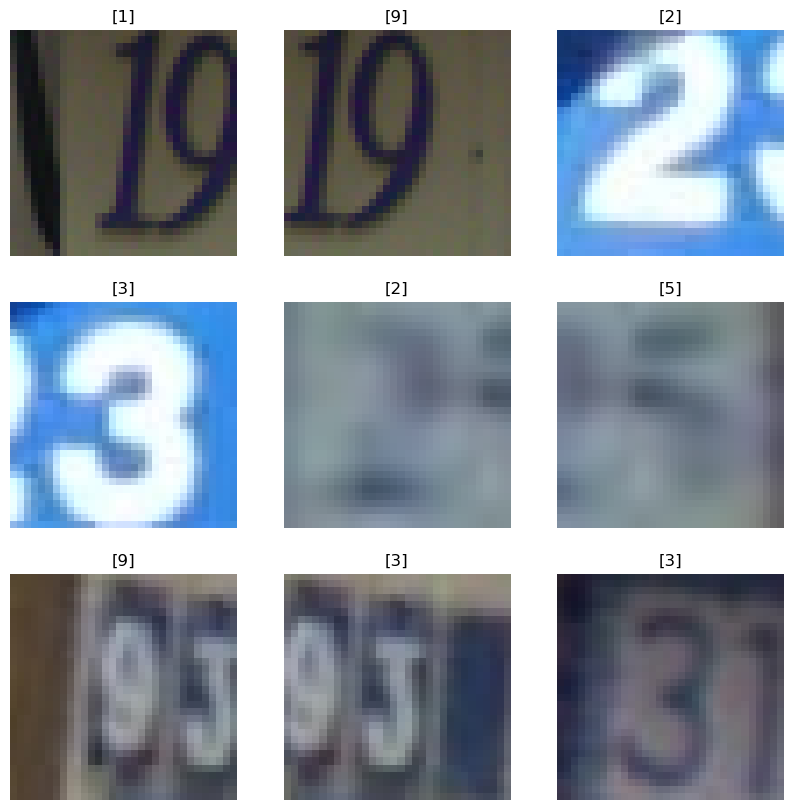

In [6]:
plot_sample_images(train_data, train_labels)

You can see that the 32 x 32 images contain distracting numbers to the side making it a real-world issue to solve.

Below, I am creating a function to display the distribution of the labels in the datasets.

In [7]:
import numpy as np
import seaborn as sns

def label_count_plot(labels, x_axis, y_axis, title, axis=None):
    """
    Creates a bar plot to visualize the count of unique labels in a dataset.

    Parameters:
    -----------
    labels : array-like
        A list, array, or similar structure containing categorical data.
    x_axis : str
        The label for the x-axis of the plot.
    y_axis : str
        The label for the y-axis of the plot.
    title : str
        The title of the bar plot.

    Returns: None
    --------
    """

    # Get unique labels and their counts from the input data
    unqique, counts = np.unique(labels, return_counts=True)

    # Combine the unique labels and their counts into a dictionary
    dict_counts =  dict(zip(unqique, counts))

    # Create a bar plot using Seaborn
    # x-axis: unique labels
    # y-axis: counts of each label
    # Set the axis labels and title of the plot
    sns.barplot(dict_counts, x=dict_counts.keys(), y= dict_counts.values(),
                 ax=axis).set(xlabel=x_axis, ylabel=y_axis, title=title) 


Plotting the datasets Label distributions.

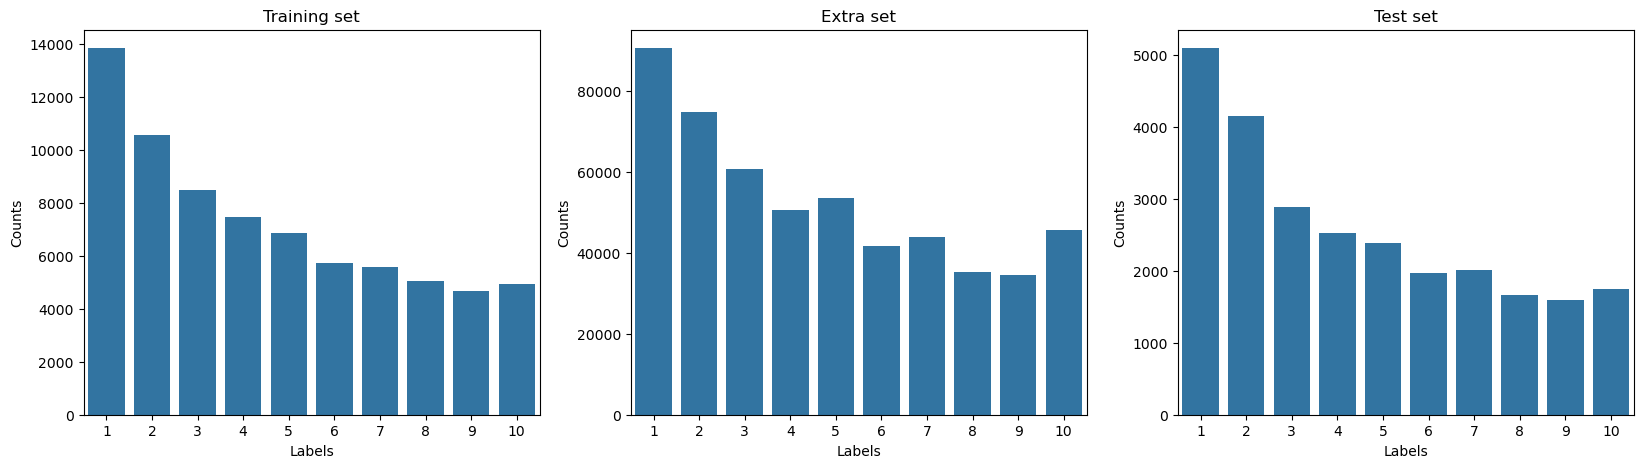

In [8]:
# Create a subplot in a 3x3 grid
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
label_count_plot(train_labels, "Labels", "Counts", "Training set", axis=ax[0])
label_count_plot(extra_labels, "Labels", "Counts", "Extra set", axis=ax[1])
label_count_plot(test_labels, "Labels", "Counts", "Test set", axis=ax[2])

You can see from the plots above that the data is imbalanced. I will have to address this imbalance in order to create an accurate model. All the dataset have more or less the same distribution imbalances.

# Pre-Processing

Here I will pre-process the dataset for training. I will be using the same method as ( Sermanet, Pierre, Chintala, Soumith, and LeCun, Yann ) in their paper 'Convolutional neural networks applied to house numbers digit classification'. 

In [9]:
# Function to create a validation set

def create_validation_set(X, y, num_samples_per_class):

    # Array: Stores the unique classes of label set
    unique_classes = np.unique(y)

    # List: To store chosen indexes                   
    chosen_indexes = []                             
    
    # Loop: iterate through each class
    for cls in unique_classes:                      

        # Array: Store all indexes from a class
        class_indexes = np.where(y == cls)[0]       

        # Array: Randomly select n indices from 'class_indexes'
        chosen_class_indexes = np.random.choice(class_indexes, num_samples_per_class, replace=False)
        # List:  Add each class indices to a list
        chosen_indexes.extend(chosen_class_indexes)

    # Array: Convert list to Numpy Array
    chosen_indexes = np.array(chosen_indexes)

    # Array:  Return the selected samples, label and indexes
    return X[:, :, :, chosen_indexes], y[chosen_indexes], chosen_indexes


## Validation Set
To build a validation set, we select 400 samples per class from the training set and 200 samples per class from the extra set. The remaining digits of the train and extra sets are used for training.

In [10]:
# Creating Validation Function

# Choose 400 samples from the training set for each class.
X_val_train, y_val_train, val_train_indexes = create_validation_set(train_data, train_labels, 400)

# Choose 200 samples from the extra set for each class.
X_val_extra, y_val_extra, val_extra_indexes = create_validation_set(extra_data, extra_labels, 200)

# Merge the two sets' validation samples.
X_val = np.concatenate((X_val_train, X_val_extra), axis=3)  # Combine along the 4th dimension
y_val = np.concatenate((y_val_train, y_val_extra), axis=0)

print('Validation data:', X_val.shape ,'Validation Labels:', y_val.shape)



Validation data: (32, 32, 3, 6000) Validation Labels: (6000, 1)


There are 6000 samples in the dataset.

Below, I am plotting the distribution of the validation set.

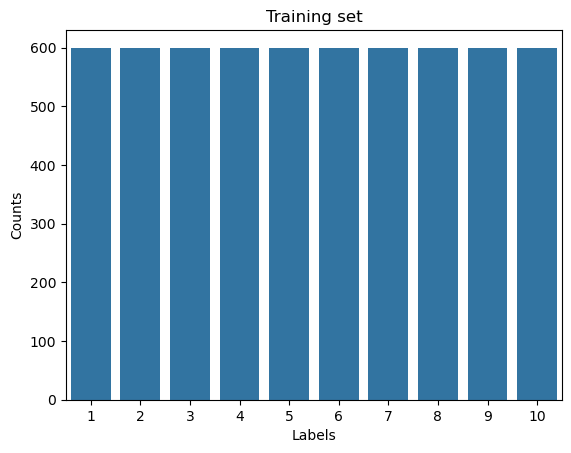

In [11]:
label_count_plot(y_val, "Labels", "Counts", "Training set")

The validation set has an equal distribution.

A function to Shuffle the datasets

In [12]:
def shuffle_dataset(data, labels):

    # Create a random number generator with a fixed seed
    seed = 42
    rng = np.random.default_rng(seed)

    # Generate indexes for the validation set
    shuffle_indexes = np.arange(labels.shape[0])  # Create an array of indexes
    rng.shuffle(shuffle_indexes)  # Shuffle the indexes in-place

    # Reorder X_val and y_val using the shuffled indexes
    shuffled_data = data[:, :, :, shuffle_indexes]
    shuffled_labels = labels[shuffle_indexes]

    return shuffled_data, shuffled_labels

Shuffling the Validation set

In [13]:
X_val, y_val = shuffle_dataset(X_val, y_val)

Plotting 9 sample from the validation set.

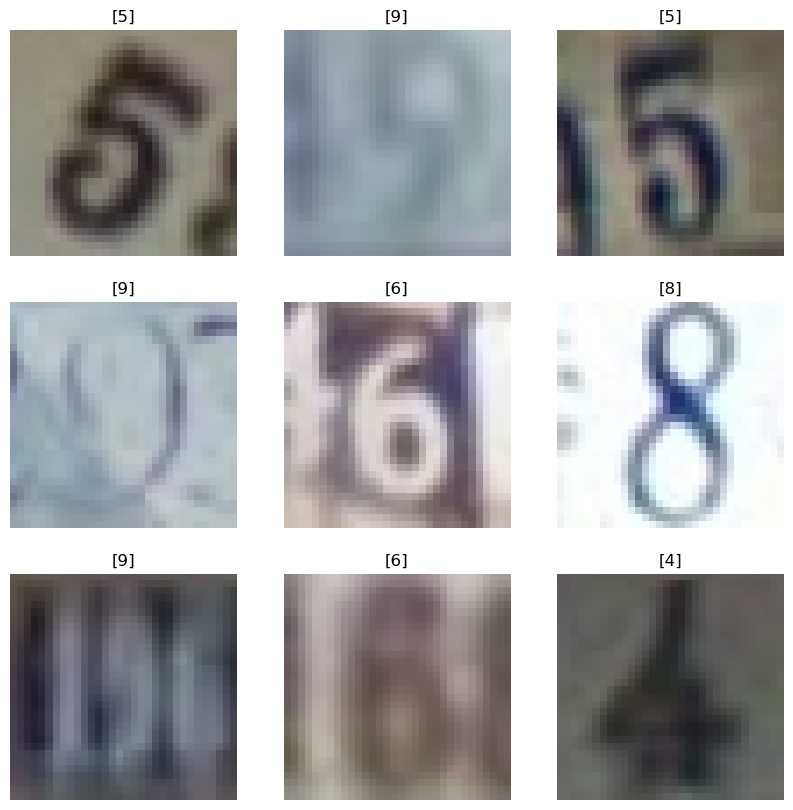

In [14]:
plot_sample_images(X_val, y_val)

## Training Set

Below, I will now remove the validation samples from the training and datasets.

In [15]:
# Remove validation samples from the original training set
X_train_new = np.delete(train_data, val_train_indexes, axis=3)
y_train_new = np.delete(train_labels, val_train_indexes, axis=0)

X_extra_new = np.delete(extra_data, val_extra_indexes, axis=3)
y_extra_new = np.delete(extra_labels, val_extra_indexes, axis=0)




print('===================================================================')
print('Original Shape')
print('Training Data:', train_data.shape, 'Training Labels:', train_labels.shape)
print('Extra Data:', extra_data.shape, 'Extra Lables:', extra_labels.shape)
print('===================================================================')
print('New Shape')
print('Training Data:', X_train_new.shape, 'Training Labels:', y_train_new.shape)
print('Extra Data:', X_extra_new.shape, 'Extra Lables:', y_extra_new.shape)

Original Shape
Training Data: (32, 32, 3, 73257) Training Labels: (73257, 1)
Extra Data: (32, 32, 3, 531131) Extra Lables: (531131, 1)
New Shape
Training Data: (32, 32, 3, 69257) Training Labels: (69257, 1)
Extra Data: (32, 32, 3, 529131) Extra Lables: (529131, 1)


Above, You can see the new datasets size after removing the validation samples

Below, I will now merge the training set and extra set together to create 1 training set.

In [16]:
# Merge the two sets' training data samples.
X_train_merge = np.concatenate((X_train_new, X_extra_new), axis=3)  # Combine along the 4th dimension
y_train_merge = np.concatenate((y_train_new, y_extra_new), axis=0)

print('New training set Data:', X_train_merge.shape, 'New Training set Labels:', y_train_merge.shape)

New training set Data: (32, 32, 3, 598388) New Training set Labels: (598388, 1)


Above, You can see there are now just under 600,00 samples

Shuffling the Merged data set

In [17]:
X_train_merge, y_train_merge = shuffle_dataset(X_train_merge, y_train_merge)

Plotting the new merged dataset samples.

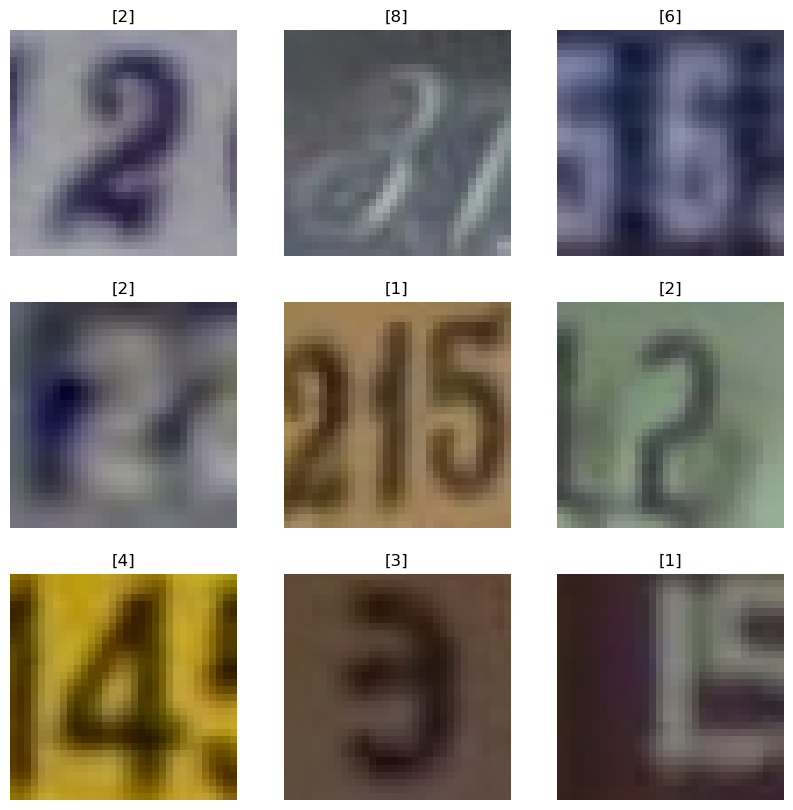

In [18]:
plot_sample_images(X_train_merge, y_train_merge)

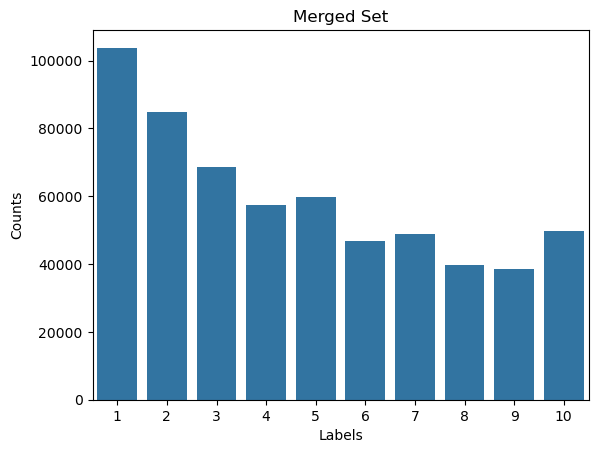

In [19]:
label_count_plot(y_train_merge, "Labels", "Counts", "Merged Set")

## Converting data types and Reshaping

Below, I am converting the training set to float32 and the label set to int32 for better compatibility with the Keras model.

In [20]:
# Convert sets to float32
X_train_float = X_train_merge.astype('float32')     # Training Set Data
X_val_float = X_val.astype('float32')               # Validation Set Data
test_data_float  = test_data.astype('float32')      # Test set Data

y_train_merge = y_train_merge.astype('int32')       # Train set Labels
y_val = y_val.astype('int32')                       # Validation set labels


Below, I am reshaping the data to better match the Tensorflow/Keras standard of (batch_size, height, width, depth)

In [21]:
#Reshape

X_train_reshaped = np.transpose(X_train_float, (3, 0, 1, 2))        # Shape: (32, 32, 3, 598388)
X_val_reshaped = np.transpose(X_val_float, (3, 0, 1, 2))            # Shape: (32, 32, 3, 6000)
test_data_reshaped = np.transpose(test_data_float, (3, 0, 1, 2))    # Shape: (32, 32, 3, 26032)


print("Training data", X_train_reshaped.shape, "Training Labels", y_train_merge.shape )
print("Validation data", X_val_reshaped.shape, "598388, 32, 32, Validation Labels", y_val.shape )
print("Test data", test_data_reshaped.shape, "Test Labels", test_labels.shape)

Training data (598388, 32, 32, 3) Training Labels (598388, 1)
Validation data (6000, 32, 32, 3) 598388, 32, 32, Validation Labels (6000, 1)
Test data (26032, 32, 32, 3) Test Labels (26032, 1)


In [22]:
len(X_train_reshaped)

598388

## Normalization

Normalize the data to a common scale for more efficient training.

In [23]:
# Create the Normalization object
norm_layer = tf.keras.layers.Normalization(axis=-1)

# Fit the training data to calculate the mean and Variance
norm_layer.adapt(X_train_reshaped)

In [24]:
print("Mean:", norm_layer.mean.numpy())  # Should output the computed mean
print("Variance:", norm_layer.variance.numpy())  # Should output the computed variance

Mean: [[[[109.86834 109.68336 113.76857]]]]
Variance: [[[[2511.2256 2556.9028 2585.6545]]]]


Apply normalization to the training and validation sets.

In [25]:
# Normalize Data

with tf.device('/CPU:0'):
    X_train_normalized = norm_layer(X_train_reshaped)
    X_val_normalized = norm_layer(X_val_reshaped)
    test_normalized = norm_layer(test_data_reshaped)

Checking the Images after normalization.

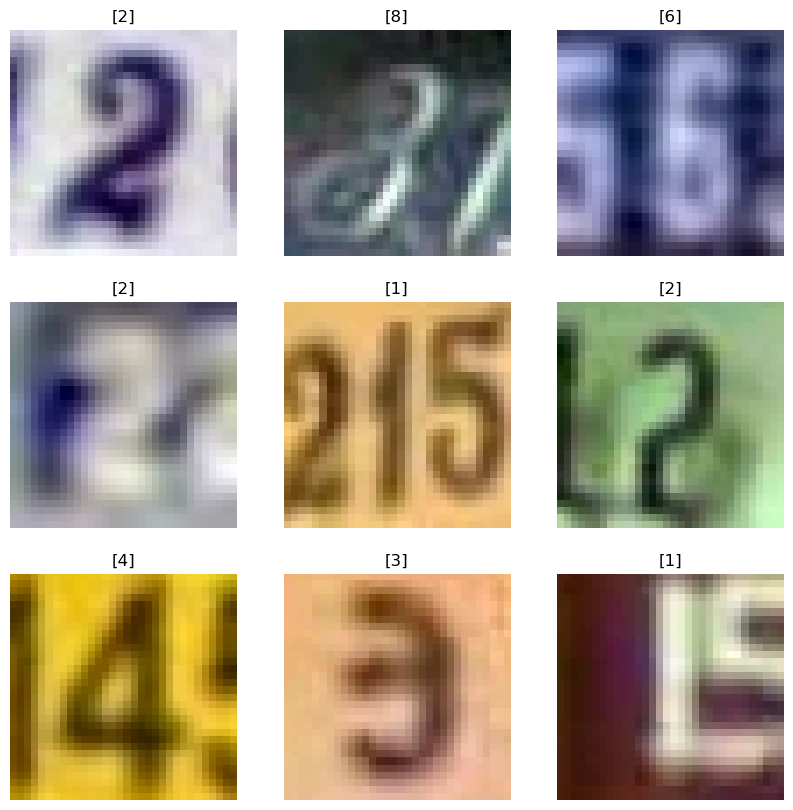

In [27]:

plt.figure(figsize=(10, 10))

# Loop over the first 9 images in the dataset
for i in range(9):
    
    # Create a subplot in a 3x3 grid
    ax = plt.subplot(3, 3, i + 1)
    
    # https://stackoverflow.com/questions/1456000/rescaling-ranges
    rescaled_image = (X_train_normalized [i, :, :, :] - tf.reduce_min(
                          X_train_normalized [i, :, :, :])) / (tf.reduce_max(
                              X_train_normalized [i, :, :, :]) - tf.reduce_min(
                                  X_train_normalized [i, :, :, :]))

    # Display the i-th image from the 'train_data'    
    plt.imshow(rescaled_image)
    
    # Set the title of the subplot to the corresponding label in 'train_labels'
    plt.title(y_train_merge[i])
    
    # Turn off the axis to remove ticks and labels for a cleaner display
    plt.axis("off")


The images look brighter after normalization.

## Common Baseline Model

Since I know my data distribution is imbalanced I will calculate the sample weight for each class to get a accurate accuracy score for my baseline.

In [28]:
# Imbalanced Dataset Compute Class Weights
# https://www.geeksforgeeks.org/how-to-handle-class-imbalance-in-tensorflow/

from sklearn.utils import class_weight


# Reshape the labels for sample_weights
y_flat_cw = y_train_merge.flatten()

# calculate the sample weights
sp_weights = class_weight.compute_sample_weight(class_weight="balanced", y=y_flat_cw)

# Create a dictionary with the Sampple weights results
sample_weights = dict(enumerate(sp_weights))

Below, I need to convert the dictionary values to a numpy array so they can be processed by the dummy classier.

In [29]:
# class_weights_array = np.array(list(class_weights.values()))
# class_weights_array

# Convert the dictionary to a numpy array
sample_weights_array = np.array(list(sample_weights.values()))
sample_weights_array

array([0.70627088, 1.50337412, 1.28109786, ..., 1.55364923, 0.87149806,
       0.70627088])

Below, I need to flatten the training data so it can be used with the dummy classier.

In [30]:
# Reshaping for Dummy Classifier
# Let numpy figure out the shape automatically with -1

# Reshape the image data to (n_samples, n_features)
X_train_flattened = X_train_merge.reshape(X_train_merge.shape[3], -1)   # Shape: (598388, 32, 32, 3)
X_val_flattened = X_val.reshape(X_val.shape[3], -1)                     # Shape: (6000, 32, 32, 3)

print('Flattened Training data:', X_train_flattened.shape, 'Flattened Validation Data:', X_val_flattened.shape )

Flattened Training data: (598388, 3072) Flattened Validation Data: (6000, 3072)


Running the dummy classifier on the Training data and evaluating on the validation set. Calculating the accuracy

In [31]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Fit the dummy

# Initialize and fit DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)

dummy_clf.fit(X_train_flattened, y_train_merge, sample_weight=sample_weights_array)


# Get predictions on the validation set
y_pred = dummy_clf.predict(X_val_flattened)

# Evaluate accuracy
baseline_accuracy = accuracy_score(y_val, y_pred)
print(f"Baseline Accuracy (Stratified): {baseline_accuracy * 100:.2f}%")

Baseline Accuracy (Stratified): 10.07%


The accuracy is currently around 10%, which is expected for a random guess in a balanced dataset with 10 classes (digits 0–9). I applied a sample weight dictionary to the model to assign higher weights to the underrepresented labels, ensuring that the model pays more attention to them during training. To demonstrate that the machine learning model is learning patterns in the data and achieving statistical accuracy, I would expect it to perform significantly better than 10% accuracy

## Converting Labels to a One hot encoded array

I am using the 'categorical_crossentropy' loss function which expects one hot encoded values. First I will change the way the digit 0 is labelled. At the moment digit 0 is labelled as 10. I will re-label it a 0

In [32]:
# Convert 10 to 0 for all label sets

import numpy as np

# Replace label 10 with 0
y_train_relabelled = np.where(y_train_merge == 10, 0, y_train_merge)
y_val_relabelled = np.where(y_val == 10, 0, y_val)
y_test_relabelled = np.where(test_labels == 10, 0, test_labels)

# Validate the labels
print("Unique values in adjusted y_train_merge:", np.unique(y_train_relabelled ))
print("Unique values in adjusted y_val:", np.unique(y_val_relabelled ))
print("Unique values in adjusted test_labels:", np.unique(y_test_relabelled ))

Unique values in adjusted y_train_merge: [0 1 2 3 4 5 6 7 8 9]
Unique values in adjusted y_val: [0 1 2 3 4 5 6 7 8 9]
Unique values in adjusted test_labels: [0 1 2 3 4 5 6 7 8 9]


One hot encoded the labels below.

In [33]:
# Import module
from sklearn.preprocessing import OneHotEncoder

# Fit the OneHotEncoder ot the training labels
enc = OneHotEncoder().fit(y_train_relabelled)

# Transform the label values to a one-hot-encoding scheme
y_train_oh = enc.transform(y_train_relabelled).toarray()
y_val_oh = enc.transform(y_val_relabelled).toarray()
y_test_oh = enc.transform(y_test_relabelled).toarray()

Below, I am computing the class weights of the training data. This will be used with the classification model to make sure when the accuracy is calculated the imbalance is taken into account.

In [34]:
# Reference: https://stackoverflow.com/questions/43481490/keras-class-weights-class-weight-for-one-hot-encoding
from sklearn.utils import class_weight


y_integers = np.argmax(y_train_oh, axis=1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)

d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 1.1992224137239968,
 1: 0.5763650899143719,
 2: 0.7062708763647093,
 3: 0.8714980629751536,
 4: 1.0408376963350785,
 5: 1.0011175801378571,
 6: 1.2810978612258879,
 7: 1.2213994121489222,
 8: 1.5033741175288295,
 9: 1.5536492275736726}

## Converting to Tensor

In [35]:
with tf.device('/cpu:0'):
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_normalized, y_train_oh))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val_normalized, y_val_oh))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_normalized, y_test_oh))


In [36]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [37]:
Stop Here!

SyntaxError: invalid syntax (2475955567.py, line 1)

# Simple Classification Model

for the first evaluation I will compare 2 models with the same architecture but using differentr activation functions. I want to confirm if Maxout networks offer any benefits over the Relu function. Before I proceed in fine tuning and using more sophisticated techniques.

The first model I will use will be focussed around the model in Maxout Networks by (Ian J. Goodfellow, David Warde-Farley, Mehdi Mirza, Aaron Courville, Yoshua Bengio) 2013. I will use the same structure of the model used in the paper but with the Relu activation function. In the second Model I will use the Maxout Activation function. The structure of both the model will be as follow:

1. Three Convolutional Layers:

    - As stated before the activation function will either be Maxout or Relu depending on the Model.

1. One Fully Connected Layer with activation function:

    - After the convolutional layers, a dense (fully connected) with either Maxout or Relu will be used.

1. One Fully Connected Softmax Layer:

    - A standard softmax layer is used at the output for final digit classification.

1. Dropout Regularization:

    - Dropout will be applied to each layer onf the model. I will use a setting of 0.2 for the convolutional layers and 0.5 for the dense layers.



## Model 1: Relu - No Dropout

In [48]:
import tensorflow as tf

# Build the model
def simple_relu_model():
    model = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer  

            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),                 # Convolutional layer
            tf.keras.layers.MaxPooling2D((2, 2)),
            

            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),                 # Convolutional layer
            tf.keras.layers.MaxPooling2D((2, 2)),
            

            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),                 # Convolutional layer
            tf.keras.layers.MaxPooling2D((2, 2)),        

            tf.keras.layers.Flatten(),

            tf.keras.layers.Dense(256, activation='relu'),

            tf.keras.layers.Dense(10, activation='softmax')    # Output layer for 10 classes
        ]
    )
    return model

In [49]:
iniital_relu_model = simple_relu_model()

# Saving Weight for Reproduce ability
iniital_relu_model.save_weights("Saved Models/iniital_relu_model.weights.h5")


In [50]:
# Compile the model
iniital_relu_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
iniital_relu_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 2, 128)       

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)


best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath="simple_relu_model.keras",
        save_best_only=True,
        monitor="val_loss")
]

simple_relu_model_time = TimeHistory()

simple_relu_model_history = iniital_relu_model.fit(
    train_dataset,                                  # Training data and labels
    validation_data=(val_dataset),                  # Validation data and labels
    epochs=100,                                     # Number of epochs
    class_weight=d_class_weights,                   # Adding Class Weights
    callbacks=[best_model, simple_relu_model_time],             # Callbacks
    verbose=1                                       # Verbosity mode (1 for progress bar)
)

Epoch 1/100
4675/4675 [==============================] - 26s 5ms/step - loss: 0.2176 - accuracy: 0.9396 - val_loss: 0.2380 - val_accuracy: 0.9323
Epoch 2/100
4675/4675 [==============================] - 21s 4ms/step - loss: 0.1135 - accuracy: 0.9688 - val_loss: 0.2042 - val_accuracy: 0.9427
Epoch 3/100
4675/4675 [==============================] - 21s 4ms/step - loss: 0.0919 - accuracy: 0.9748 - val_loss: 0.2015 - val_accuracy: 0.9453
Epoch 4/100
4675/4675 [==============================] - 20s 4ms/step - loss: 0.0783 - accuracy: 0.9784 - val_loss: 0.2017 - val_accuracy: 0.9465
Epoch 5/100
4675/4675 [==============================] - 20s 4ms/step - loss: 0.0693 - accuracy: 0.9806 - val_loss: 0.2261 - val_accuracy: 0.9425
Epoch 6/100
4675/4675 [==============================] - 20s 4ms/step - loss: 0.0623 - accuracy: 0.9823 - val_loss: 0.2330 - val_accuracy: 0.9445
Epoch 7/100
4675/4675 [==============================] - 22s 5ms/step - loss: 0.0569 - accuracy: 0.9834 - val_loss: 0.2473 -

In [40]:
np.save('Saved Models/simple_relu_model_history.npy',simple_relu_model_history.history)

In [41]:
iniital_relu_model.save("saved models/simple_relu_model.keras")

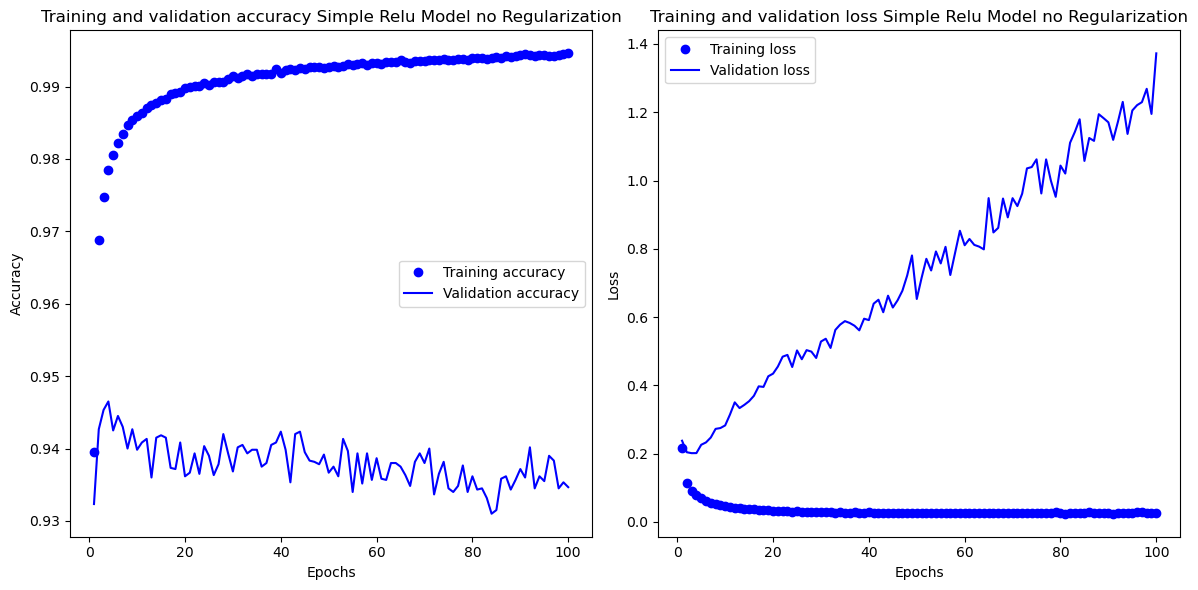

In [ ]:
import importlib
import utils.plotting
from utils.plotting import plot_accuracy_metric
importlib.reload(utils.plotting)
import pandas as pd

simple_relu_model_history_pd = pd.DataFrame(simple_relu_model_history.history)

plot_accuracy_metric(simple_relu_model_history_pd, 'Simple Relu Model no Regularization')

In [43]:
from datetime import timedelta


simple_relu_model_time_result = simple_relu_model_time.times
simple_relu_model_average_time = timedelta(seconds=np.mean(simple_relu_model_time_result))
simple_relu_model_total_time = timedelta(seconds=np.sum(simple_relu_model_time_result))
print('Total Time:', str(simple_relu_model_total_time), 'Average Epoch Time:', str(simple_relu_model_average_time))

Total Time: 0:34:36.030121 Average Epoch Time: 0:00:20.760301


In [81]:
simple_relu_model_best = tf.keras.models.load_model('simple_relu_model.keras')

In [213]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import count_dead_neurons, count_dead_neurons_v2


relu_no_dropout = count_dead_neurons_v2(test_dataset, simple_relu_model_best )

In [165]:
len(train_dataset)

TypeError: 'BatchDataset' object is not subscriptable

<Axes: xlabel='layer', ylabel='Number of Dead neurons in %'>

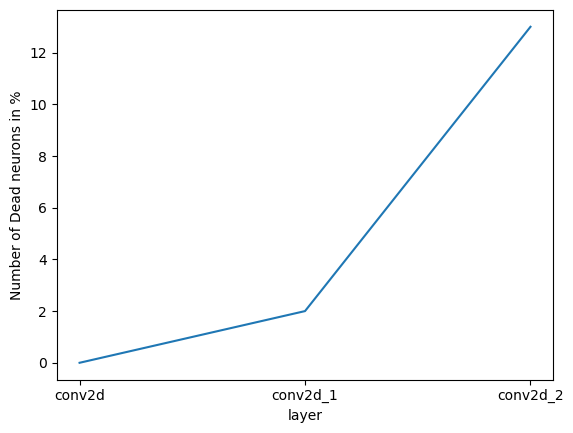

In [214]:
sns.lineplot(data=relu_no_dropout, x='layer', y='Number of Dead neurons in %')

In [51]:
simple_relu_model_best.evaluate(test_dataset)

204/204 [==============================] - 1s 4ms/step - loss: 0.2182 - accuracy: 0.9454


[0.21817104518413544, 0.94541335105896]

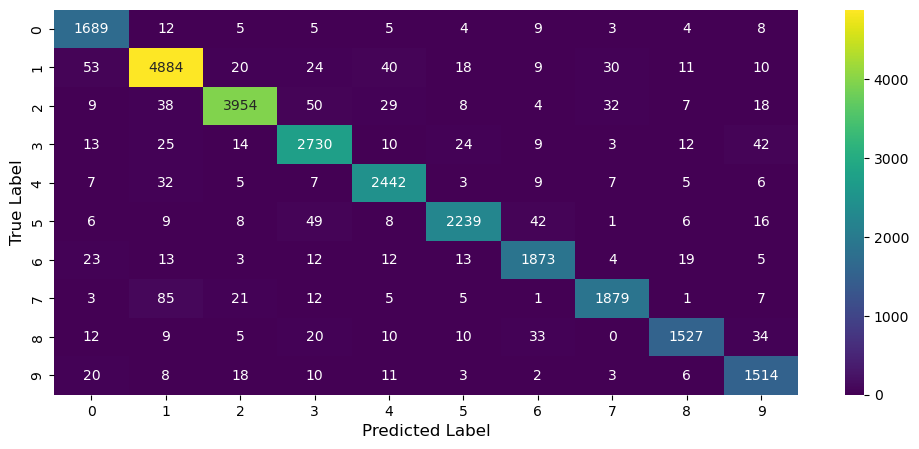

In [48]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import generate_confusion_matrix


generate_confusion_matrix(simple_relu_model_best, test_dataset)

# Model 2: Simple Model with Dropout V2

In [65]:
import tensorflow as tf
import tensorflow_addons as tfa
from keras import activations

def simple_model_Relu_with_dropout():

    # Build the model
    model = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer
            tf.keras.layers.Dropout(0.2),

            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),                 # Convolutional layer    
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.5),
            

            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),                 # Convolutional layer    
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Dropout(0.5),
            

            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),                 # Convolutional layer    
            tf.keras.layers.MaxPooling2D((2, 2)), 
            tf.keras.layers.Dropout(0.5),
            

            tf.keras.layers.Flatten(),

            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.5),

            tf.keras.layers.Dense(10, activation='softmax'),    # Output layer for 10 classes        
        ]
    )
    return model



In [66]:
initial_relu_model_with_dropout = simple_relu_model()

# Saving Weight for Reproduce ability
initial_relu_model_with_dropout.save_weights("Saved Models/initial_relu_model_with_dropout.weights.h5")

In [67]:
# Compile the model
initial_relu_model_with_dropout.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
initial_relu_model_with_dropout.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 2, 2, 128)       

In [ ]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)


best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath="best_simple_relu_model_with_dropout_v2.keras",
        save_best_only=True,
        monitor="val_loss")
]

simple_relu_model_time_with_dropout_v2 = TimeHistory()


simple_relu_model_history_with_dropout_v2 = initial_relu_model_with_dropout.fit(
    train_dataset,                                  # Training data and labels
    validation_data=(val_dataset),                  # Validation data and labels
    epochs=100,                                     # Number of epochs
    class_weight=d_class_weights,                   # Adding Class Weights
    callbacks=[best_model, simple_relu_model_time_with_dropout_v2],             # Callbacks
    verbose=1                                       # Verbosity mode (1 for progress bar)
)

Epoch 1/100
4675/4675 [==============================] - 24s 5ms/step - loss: 0.8218 - accuracy: 0.7387 - val_loss: 0.3923 - val_accuracy: 0.8798
Epoch 2/100
4675/4675 [==============================] - 23s 5ms/step - loss: 0.5070 - accuracy: 0.8488 - val_loss: 0.3653 - val_accuracy: 0.8887
Epoch 3/100
4675/4675 [==============================] - 23s 5ms/step - loss: 0.4696 - accuracy: 0.8602 - val_loss: 0.3527 - val_accuracy: 0.8925
Epoch 4/100
4675/4675 [==============================] - 23s 5ms/step - loss: 0.4531 - accuracy: 0.8655 - val_loss: 0.3456 - val_accuracy: 0.8923
Epoch 5/100
4675/4675 [==============================] - 23s 5ms/step - loss: 0.4436 - accuracy: 0.8682 - val_loss: 0.3139 - val_accuracy: 0.9065
Epoch 6/100
4675/4675 [==============================] - 23s 5ms/step - loss: 0.4362 - accuracy: 0.8710 - val_loss: 0.3274 - val_accuracy: 0.9013
Epoch 7/100
4675/4675 [==============================] - 23s 5ms/step - loss: 0.4299 - accuracy: 0.8731 - val_loss: 0.3263 -

In [ ]:
np.save('Saved Models/simple_relu_model_history_with_dropout_v2.npy',simple_relu_model_history_with_dropout_v2.history)

In [ ]:
initial_relu_model_with_dropout.save("saved models/simple_relu_model_with_dropout_v2.keras")

In [ ]:
# use .item to load dict from npy file

simple_relu_model_history_with_dropout_v2 = np.load('saved models/simple_relu_model_history_with_dropout_v2.npy', allow_pickle=True).item()

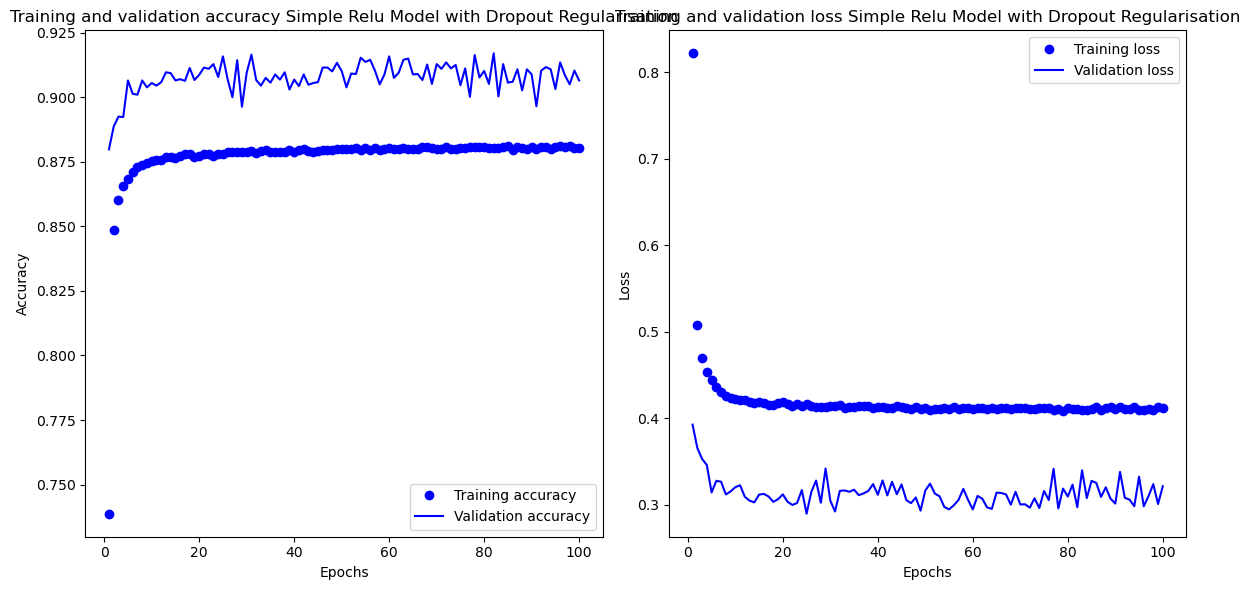

In [ ]:
import importlib
import utils.plotting
from utils.plotting import plot_accuracy_metric
importlib.reload(utils.plotting)
import pandas as pd

simple_relu_model_history_with_dropout_df_v2 = pd.DataFrame(simple_relu_model_history_with_dropout_v2)

plot_accuracy_metric(simple_relu_model_history_with_dropout_df_v2, 'Simple Relu Model with Dropout Regularisation')

In [ ]:
from datetime import timedelta


simple_relu_model_with_dropout_time_result_v2 = simple_relu_model_time_with_dropout_v2.times
simple_relu_model_with_dropout_average_time_v2 = timedelta(seconds=np.mean(simple_relu_model_with_dropout_time_result_v2))
simple_relu_model_with_dropout_total_time_v2 = timedelta(seconds=np.sum(simple_relu_model_with_dropout_time_result_v2))
print('Total Time:', str(simple_relu_model_with_dropout_total_time_v2), 'Average Epoch Time:', str(simple_relu_model_with_dropout_average_time_v2))

Total Time: 0:37:45.343163 Average Epoch Time: 0:00:22.653432


In [82]:
simple_relu_model_best_with_dropout_v2 = tf.keras.models.load_model('best_simple_relu_model_with_dropout_v2.keras')

In [83]:
import importlib
import utils.statistics
from utils.statistics import count_dead_neurons
importlib.reload(utils.statistics)

relu_with_dropout_v2 = count_dead_neurons_v2(test_dataset, simple_relu_model_best_with_dropout_v2 )

<Axes: xlabel='layer', ylabel='Number of Dead neurons in %'>

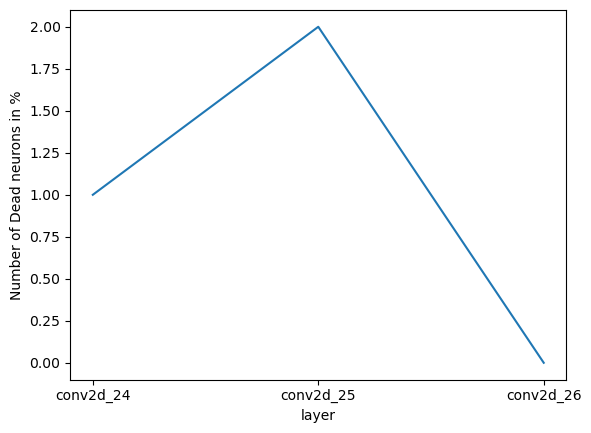

In [84]:
sns.lineplot(data=relu_with_dropout_v2, x='layer', y='Number of Dead neurons in %')

In [ ]:
simple_model_Relu_with_dropout_v2.evaluate(test_dataset)
simple_model_Relu_with_dropout_v2.evaluate(test_dataset)

204/204 [==============================] - 1s 4ms/step - loss: 0.3111 - accuracy: 0.9179


[0.31107962131500244, 0.9178703427314758]

In [ ]:

simple_relu_model_best_with_dropout_v2.evaluate(test_dataset)


204/204 [==============================] - 1s 3ms/step - loss: 0.2935 - accuracy: 0.9234


[0.29350507259368896, 0.923401951789856]

In [ ]:
simple_model_Relu_with_dropout_v2 = tf.keras.models.load_model('saved models/simple_relu_model_with_dropout_v2.keras')

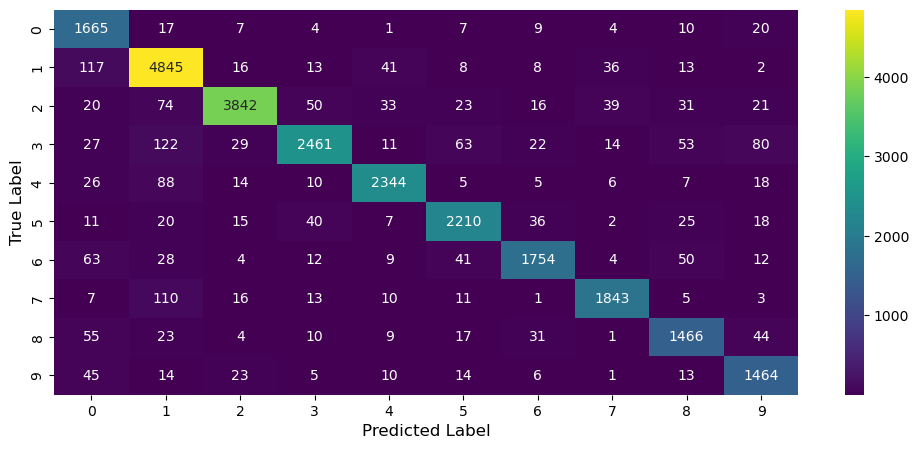

In [ ]:
generate_confusion_matrix(simple_model_Relu_with_dropout_v2, test_dataset)

## Model 3: Simple Relu Model with Dropblock

In [86]:
import tensorflow as tf
import tensorflow_addons as tfa
from keras import activations
# from utils.old_DropBlock import DropBlock2D
import importlib
import utils.DropBlock
from utils.DropBlock import DropBlock2D
importlib.reload(utils.DropBlock)


def simple_model_Relu_with_dropblock():
# Build the model
    model = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer
            DropBlock2D(rate=0.2, block_size=3 ),

            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),                 # Convolutional layer
            DropBlock2D(rate=0.5, block_size=3 ),    
            tf.keras.layers.MaxPooling2D((2, 2)),    

            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),                 # Convolutional layer
            DropBlock2D(rate=0.5, block_size=3),    
            tf.keras.layers.MaxPooling2D((2, 2)), 

            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),                 # Convolutional layer
            DropBlock2D(rate=0.5, block_size=3),    
            tf.keras.layers.MaxPooling2D((2, 2)),

            tf.keras.layers.Flatten(),

            tf.keras.layers.Dense(256, activation='relu'),

            tf.keras.layers.Dense(10, activation='softmax')    # Output layer for 10 classes
        ]
    )
    return model



In [87]:
initial_relu_model_with_dropblock = simple_model_Relu_with_dropblock()

# Saving Weight for Reproduce ability
initial_relu_model_with_dropblock.save_weights("Saved Models/initial_relu_model_with_dropblock.weights.h5")

In [88]:
# Compile the model
initial_relu_model_with_dropblock.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
initial_relu_model_with_dropblock.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 drop_block2d (DropBlock2D)  (None, 32, 32, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 drop_block2d_1 (DropBlock2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 drop_block2d_2 (DropBlock2D  (None, 13, 13, 64)      

In [54]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)


best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath="simple_relu_model_with_dropblock.keras",
        save_best_only=True,
        monitor="val_loss")
]

simple_relu_model_time_with_dropblock = TimeHistory()


simple_relu_model_history_with_dropblock = initial_relu_model_with_dropblock .fit(
    train_dataset,                                  # Training data and labels
    validation_data=(val_dataset),                  # Validation data and labels
    epochs=100,                                     # Number of epochs
    class_weight=d_class_weights,                   # Adding Class Weights
    callbacks=[best_model, simple_relu_model_time_with_dropblock],             # Callbacks
    verbose=1                                       # Verbosity mode (1 for progress bar)
)

Epoch 1/100
4675/4675 [==============================] - 36s 8ms/step - loss: 0.5935 - accuracy: 0.8139 - val_loss: 0.3650 - val_accuracy: 0.8982
Epoch 2/100
4675/4675 [==============================] - 36s 8ms/step - loss: 0.3804 - accuracy: 0.8841 - val_loss: 0.3157 - val_accuracy: 0.9087
Epoch 3/100
4675/4675 [==============================] - 35s 8ms/step - loss: 0.3503 - accuracy: 0.8936 - val_loss: 0.3128 - val_accuracy: 0.9087
Epoch 4/100
4675/4675 [==============================] - 35s 8ms/step - loss: 0.3337 - accuracy: 0.8989 - val_loss: 0.3157 - val_accuracy: 0.9038
Epoch 5/100
4675/4675 [==============================] - 36s 8ms/step - loss: 0.3230 - accuracy: 0.9024 - val_loss: 0.3008 - val_accuracy: 0.9108
Epoch 6/100
4675/4675 [==============================] - 36s 8ms/step - loss: 0.3158 - accuracy: 0.9046 - val_loss: 0.2983 - val_accuracy: 0.9118
Epoch 7/100
4675/4675 [==============================] - 35s 8ms/step - loss: 0.3119 - accuracy: 0.9062 - val_loss: 0.3154 -

In [55]:
np.save('Saved Models/simple_relu_model_history_with_dropblock.npy',simple_relu_model_history_with_dropblock.history)

In [82]:
simple_relu_model_history_with_dropblock.history

{'loss': [0.5935227274894714,
  0.38037359714508057,
  0.35032498836517334,
  0.3337058126926422,
  0.3230070471763611,
  0.3157668113708496,
  0.3118785619735718,
  0.30711695551872253,
  0.30389755964279175,
  0.2987317740917206,
  0.29589056968688965,
  0.2947940528392792,
  0.293116956949234,
  0.2912186086177826,
  0.28978994488716125,
  0.2907925248146057,
  0.28808853030204773,
  0.28707629442214966,
  0.285841166973114,
  0.2864125370979309,
  0.28419816493988037,
  0.2851649522781372,
  0.2847033739089966,
  0.2834632694721222,
  0.2842453420162201,
  0.28346872329711914,
  0.2826786935329437,
  0.28233906626701355,
  0.28192633390426636,
  0.2819177210330963,
  0.28216877579689026,
  0.28139612078666687,
  0.280170202255249,
  0.2804296314716339,
  0.2795056402683258,
  0.27952811121940613,
  0.2788647711277008,
  0.2791520059108734,
  0.27748483419418335,
  0.2793237566947937,
  0.2783392071723938,
  0.2785126268863678,
  0.27790939807891846,
  0.2764365077018738,
  0.278139

In [56]:
initial_relu_model_with_dropblock.save("saved models/simple_relu_model_with_dropblock.keras")

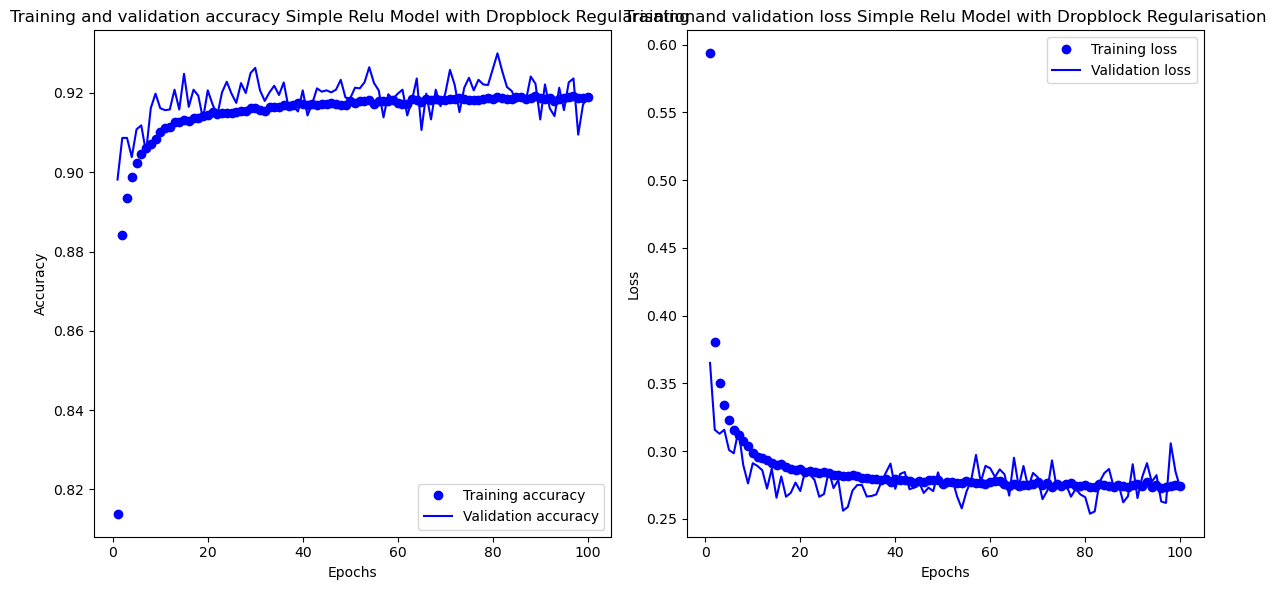

In [57]:
import importlib
import utils.plotting
from utils.plotting import plot_accuracy_metric
importlib.reload(utils.plotting)
import pandas as pd


simple_relu_model_history_with_dropblock_df = pd.DataFrame(simple_relu_model_history_with_dropblock.history)

plot_accuracy_metric(simple_relu_model_history_with_dropblock_df, 'Simple Relu Model with Dropblock Regularisation')

In [58]:
from datetime import timedelta


simple_relu_model_with_dropblock_time_result = simple_relu_model_time_with_dropblock.times
simple_relu_model_with_dropblock_average_time = timedelta(seconds=np.mean(simple_relu_model_with_dropblock_time_result))
simple_relu_model_with_dropblock_total_time = timedelta(seconds=np.sum(simple_relu_model_with_dropblock_time_result))
print('Total Time:', str(simple_relu_model_with_dropblock_total_time), 'Average Epoch Time:', str(simple_relu_model_with_dropblock_average_time))

Total Time: 0:59:39.919467 Average Epoch Time: 0:00:35.799195


In [102]:
simple_relu_model_best_with_dropblock = tf.keras.models.load_model('simple_relu_model_with_dropblock.keras', {"DropBlock2D": DropBlock2D})

In [217]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)

from utils.statistics import count_dead_neurons, count_dead_neurons_v2



relu_with_dropblock = count_dead_neurons_v2(test_dataset, simple_relu_model_best_with_dropblock )

In [136]:
relu_with_dropblock 

,layer,Number of Dead neurons in %
0,conv2d_6,0
1,conv2d_7,612
2,conv2d_8,0


<Axes: xlabel='layer', ylabel='Number of Dead neurons in %'>

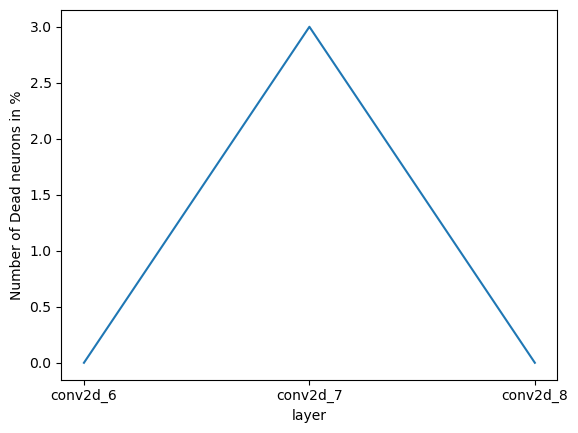

In [218]:
sns.lineplot(data=relu_with_dropblock, x='layer', y='Number of Dead neurons in %')

In [60]:
# Are you evaluating the final model or the best?

simple_relu_model_dropblock.evaluate(test_dataset)

204/204 [==============================] - 1s 3ms/step - loss: 0.2537 - accuracy: 0.9319


[0.2536535859107971, 0.9318915009498596]

In [54]:
from utils.DropBlock import DropBlock2D

simple_relu_model_dropblock = tf.keras.models.load_model('saved models/simple_relu_model_with_dropblock.keras', {"DropBlock2D": DropBlock2D})

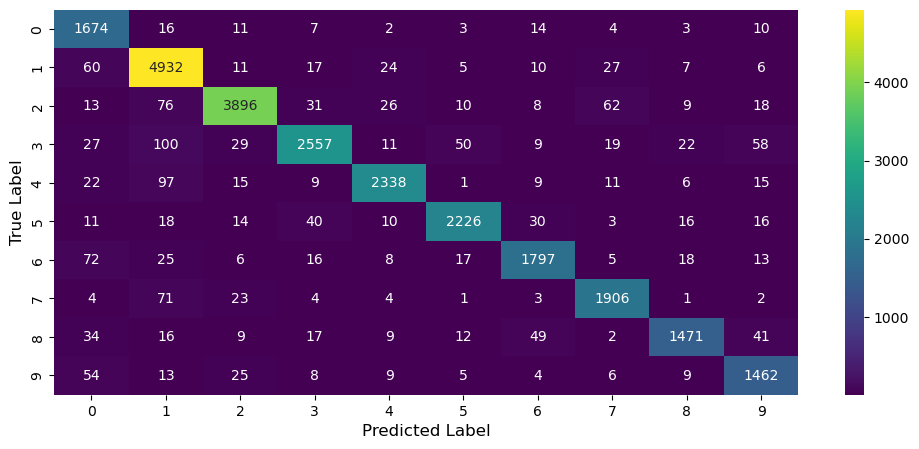

In [61]:
import importlib
import utils.plotting
importlib.reload(utils.plotting)
from utils.plotting import generate_confusion_matrix


generate_confusion_matrix(simple_relu_model_dropblock, test_dataset)

## Model 4: Nitish Srivastava Dropout: A Simple Way to Prevent Neural Networks from Overfitting

In [54]:
# Nitish Srivastava Dropout: A Simple Way to Prevent Neural Networks from Overfitting

import tensorflow as tf
import tensorflow_addons as tfa
from keras import activations
from keras.constraints import MaxNorm
from keras.optimizers import SGD

# Build the model
srivastava_dropout = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Conv2D(96, (5, 5),strides=1, activation='relu', kernel_constraint=MaxNorm(4), padding='same'),                 # Convolutional layer    
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    tf.keras.layers.Dropout(0.25),
    

    tf.keras.layers.Conv2D(128, (5, 5),strides=1, activation='relu', kernel_constraint=MaxNorm(4), padding='same'),                 # Convolutional layer    
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    tf.keras.layers.Dropout(0.25),
    

    tf.keras.layers.Conv2D(256, (5, 5),strides=1, activation='relu', kernel_constraint=MaxNorm(4), padding='same'),                 # Convolutional layer    
    tf.keras.layers.MaxPooling2D((3, 3), strides=2,), 
    tf.keras.layers.Dropout(0.5),
       

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(2048, activation='relu', kernel_constraint=MaxNorm(4)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(2048, activation='relu', kernel_constraint=MaxNorm(4)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(10, activation='softmax'),    # Output layer for 10 classes
    
])

# optimizer = Adam(beta_1=0.95)

optimizer = SGD(learning_rate=0.0001, momentum=0.99)

# Compile the model
srivastava_dropout.compile(optimizer=optimizer ,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
srivastava_dropout.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_48 (Dropout)        (None, 32, 32, 3)         0         
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 32, 96)        7296      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 15, 15, 96)       0         
 g2D)                                                            
                                                                 
 dropout_49 (Dropout)        (None, 15, 15, 96)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 15, 15, 128)       307328    
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 7, 7, 128)        0         
 g2D)                                                 

In [55]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)


best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath="srivastava_dropout_best_model.keras",
        save_best_only=True,
        monitor="val_loss")
]

srivastava_dropout_time = TimeHistory()


srivastava_dropout_history = srivastava_dropout.fit(
    train_dataset,                                  # Training data and labels
    validation_data=(val_dataset),                  # Validation data and labels
    epochs=300,                                     # Number of epochs
    class_weight=d_class_weights,                   # Adding Class Weights
    callbacks=[best_model, srivastava_dropout_time],             # Callbacks
    verbose=1                                       # Verbosity mode (1 for progress bar)
)

Epoch 1/300
4675/4675 [==============================] - 99s 21ms/step - loss: 1.4722 - accuracy: 0.4742 - val_loss: 0.4305 - val_accuracy: 0.8717
Epoch 2/300
4675/4675 [==============================] - 98s 21ms/step - loss: 0.3157 - accuracy: 0.9076 - val_loss: 0.2814 - val_accuracy: 0.9192
Epoch 3/300
4675/4675 [==============================] - 98s 21ms/step - loss: 0.2295 - accuracy: 0.9340 - val_loss: 0.2448 - val_accuracy: 0.9295
Epoch 4/300
4675/4675 [==============================] - 98s 21ms/step - loss: 0.1959 - accuracy: 0.9439 - val_loss: 0.2261 - val_accuracy: 0.9385
Epoch 5/300
4675/4675 [==============================] - 97s 21ms/step - loss: 0.1767 - accuracy: 0.9499 - val_loss: 0.2180 - val_accuracy: 0.9425
Epoch 6/300
4675/4675 [==============================] - 97s 21ms/step - loss: 0.1625 - accuracy: 0.9538 - val_loss: 0.2067 - val_accuracy: 0.9445
Epoch 7/300
4675/4675 [==============================] - 98s 21ms/step - loss: 0.1536 - accuracy: 0.9565 - val_loss: 0

In [56]:
np.save('Saved Models/srivastava_dropout.npy',srivastava_dropout_history.history)

In [57]:
srivastava_dropout.save("saved models/srivastava_dropout.keras")

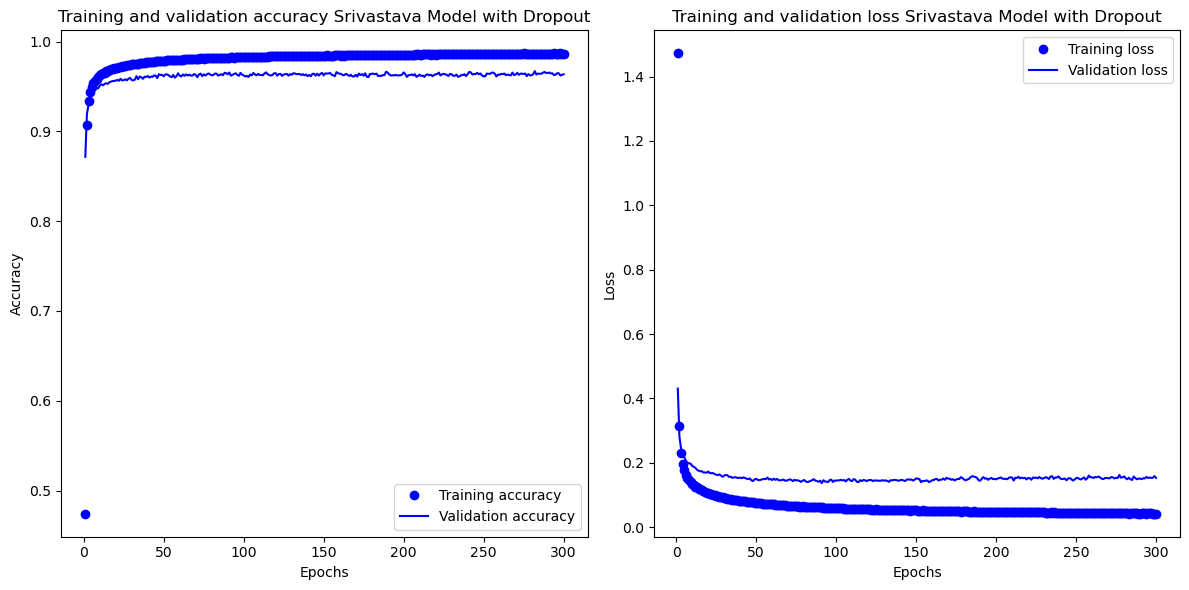

In [58]:
import importlib
import utils.plotting
from utils.plotting import plot_accuracy_metric
importlib.reload(utils.plotting)
import pandas as pd

srivastava_dropout_history_df = pd.DataFrame(srivastava_dropout_history.history)

plot_accuracy_metric(srivastava_dropout_history_df, 'Srivastava Model with Dropout')

In [59]:
from datetime import timedelta


srivastava_dropout_time_result = srivastava_dropout_time.times
srivastava_dropout_average_time = timedelta(seconds=np.mean(srivastava_dropout_time_result))
srivastava_dropout_total_time = timedelta(seconds=np.sum(srivastava_dropout_time_result))
print('Total Time:', str(srivastava_dropout_total_time), 'Average Epoch Time:', str(srivastava_dropout_average_time))

Total Time: 7:37:38.564356 Average Epoch Time: 0:01:31.528548


In [61]:
np.save('Saved Models/srivastava_dropout_average_time.npy',srivastava_dropout_average_time)
np.save('Saved Models/srivastava_dropout_total_time.npy',srivastava_dropout_total_time)

In [ ]:
import tensorflow as tf

srivastava_dropout_best_model = tf.keras.models.load_model('srivastava_dropout_best_model.keras')

In [ ]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import count_dead_neurons, count_dead_neurons_v2


srivastava_dropout_activations = count_dead_neurons(test_dataset, srivastava_dropout_best_model )

NameError: name 'train_dataset' is not defined

<Axes: xlabel='layer', ylabel='Number of Dead neurons in %'>

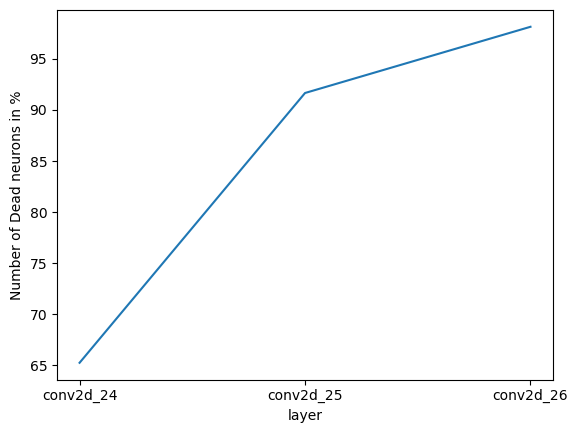

In [63]:
sns.lineplot(data=srivastava_dropout_activations, x='layer', y='Number of Dead neurons in %')

In [64]:
srivastava_dropout_best_model.evaluate(test_dataset)

204/204 [==============================] - 2s 7ms/step - loss: 0.1214 - accuracy: 0.9705


[0.12141592800617218, 0.9705362915992737]

# Results

# Data Augmentation

In [38]:
from keras import layers


data_augmentation = tf.keras.Sequential([
    layers.RandomBrightness(0.2),
    # layers.RandomContrast(0.2),
    layers.RandomZoom(0.2, fill_mode='constant', fill_value=128.),
    layers.RandomRotation(0.2)
])

In [39]:
AUTO = tf.data.AUTOTUNE
with tf.device('/cpu:0'):
    aug_train_dataset = (tf.data.Dataset.from_tensor_slices((X_train_reshaped, y_train_oh))
                        .shuffle(100)
                        .batch(128)
                        .map(lambda x, y: (data_augmentation(x),y), num_parallel_calls=AUTO)                     
                        .prefetch(AUTO)
                        )

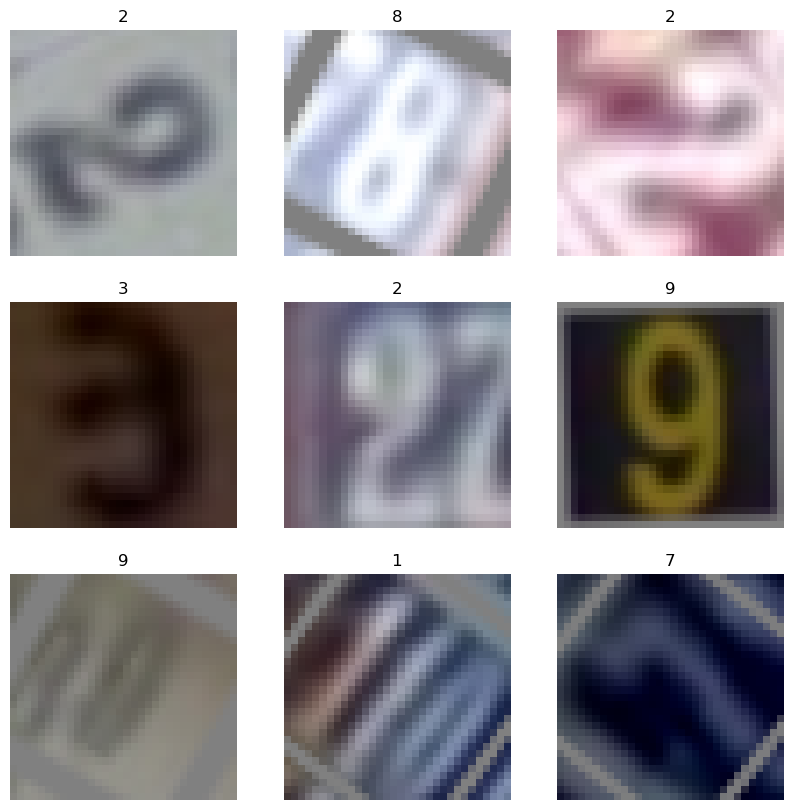

In [40]:
import keras.backend as K
image_batch, label_batch = next(iter(aug_train_dataset))
# rescaled_image = denormalizer_layer(image_batch)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)    
    # rescaled_image = (image_batch [i, :, :, :] - tf.reduce_min(
    #                       image_batch [i, :, :, :])) / (tf.reduce_max(
    #                           image_batch [i, :, :, :]) - tf.reduce_min(
    #                               image_batch [i, :, :, :]))
    plt.title(np.argmax(label_batch[i]))
    plt.imshow(K.cast(image_batch[i], dtype='uint8'))
    plt.axis("off")

In [41]:
aug_norm = tf.keras.layers.Normalization(axis=-1)

In [42]:
aug_train_dataset_features = aug_train_dataset.map(lambda x,y: x)

In [43]:
aug_norm.adapt(aug_train_dataset_features)

In [44]:
aug_train_dataset = (aug_train_dataset.shuffle(100)
                    .map(lambda x, y: (aug_norm(x),y), num_parallel_calls=AUTO)                     
                        )

# Model: Simple Relu model with Augmentation Dataset

In [55]:
initial_relu_model_with_aug = simple_relu_model()
initial_relu_model_with_aug.load_weights("Saved Models/iniital_relu_model.weights.h5")

In [56]:
# Compile the model
initial_relu_model_with_aug.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
initial_relu_model_with_aug.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 2, 2, 128)       

In [57]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)


best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath="initial_relu_model_with_aug_best.keras",
        save_best_only=True,
        monitor="val_loss")
]

# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
#                               patience=5)

initial_relu_model_with_aug_time = TimeHistory()


initial_relu_model_with_aug_history = initial_relu_model_with_aug.fit(
    aug_train_dataset,                                  # Training data and labels
    validation_data=(val_dataset),                  # Validation data and labels
    epochs=100,                                     # Number of epochs
    class_weight=d_class_weights,                   # Adding Class Weights
    callbacks=[best_model, initial_relu_model_with_aug_time ],             # Callbacks
    verbose=1                                       # Verbosity mode (1 for progress bar)
)

Epoch 1/100
4675/4675 [==============================] - 24s 5ms/step - loss: 0.4736 - accuracy: 0.8537 - val_loss: 0.4077 - val_accuracy: 0.8740
Epoch 2/100
4675/4675 [==============================] - 23s 5ms/step - loss: 0.2493 - accuracy: 0.9250 - val_loss: 0.3454 - val_accuracy: 0.9000
Epoch 3/100
4675/4675 [==============================] - 23s 5ms/step - loss: 0.2122 - accuracy: 0.9361 - val_loss: 0.3256 - val_accuracy: 0.9017
Epoch 4/100
4675/4675 [==============================] - 24s 5ms/step - loss: 0.1967 - accuracy: 0.9414 - val_loss: 0.2964 - val_accuracy: 0.9078
Epoch 5/100
4675/4675 [==============================] - 23s 5ms/step - loss: 0.1863 - accuracy: 0.9444 - val_loss: 0.2921 - val_accuracy: 0.9147
Epoch 6/100
4675/4675 [==============================] - 25s 5ms/step - loss: 0.1807 - accuracy: 0.9465 - val_loss: 0.2911 - val_accuracy: 0.9162
Epoch 7/100
4675/4675 [==============================] - 25s 5ms/step - loss: 0.1748 - accuracy: 0.9482 - val_loss: 0.2688 -

In [58]:
np.save('Saved Models/initial_relu_model_with_aug_history.npy',initial_relu_model_with_aug_history.history)
initial_relu_model_with_aug.save("saved models/initial_relu_model_with_aug.keras")

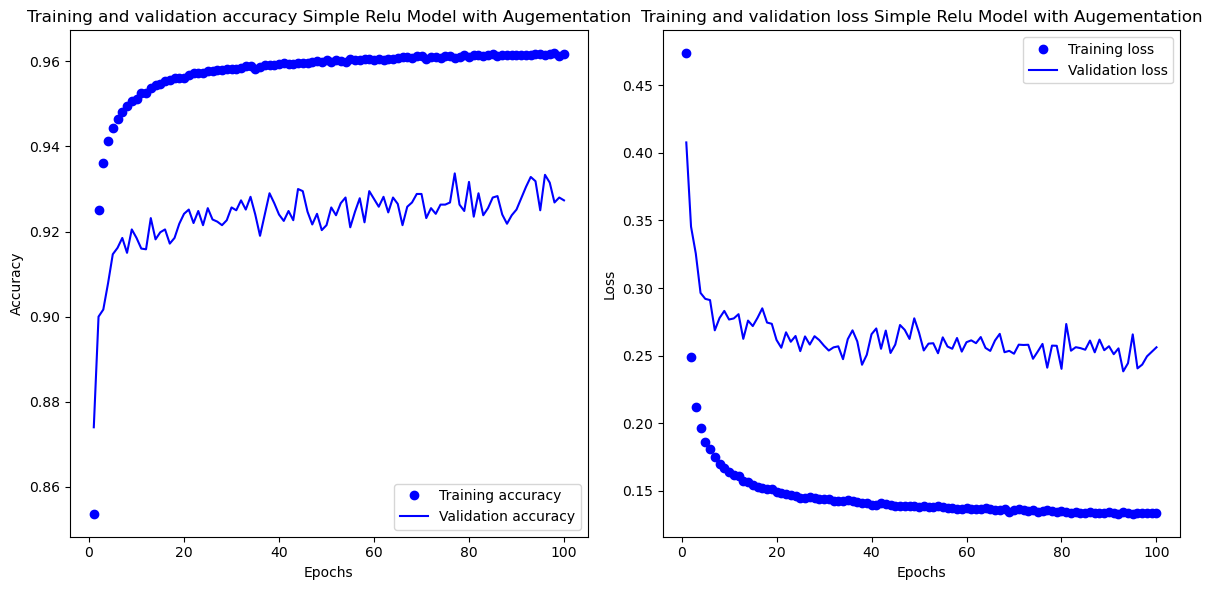

In [60]:
import importlib
import utils.plotting
from utils.plotting import plot_accuracy_metric
importlib.reload(utils.plotting)
import pandas as pd

initial_relu_model_with_aug_history_pd = pd.DataFrame(initial_relu_model_with_aug_history.history)

plot_accuracy_metric(initial_relu_model_with_aug_history_pd, 'Simple Relu Model with Augmentation')

In [61]:
initial_relu_model_with_aug_best = tf.keras.models.load_model('initial_relu_model_with_aug_best.keras')

In [62]:
import importlib
import utils.statistics
importlib.reload(utils.statistics)
from utils.statistics import count_dead_neurons, count_dead_neurons_v2


initial_relu_model_with_aug_neurons = count_dead_neurons_v2(test_dataset, initial_relu_model_with_aug_best )

<Axes: xlabel='layer', ylabel='Number of Dead neurons in %'>

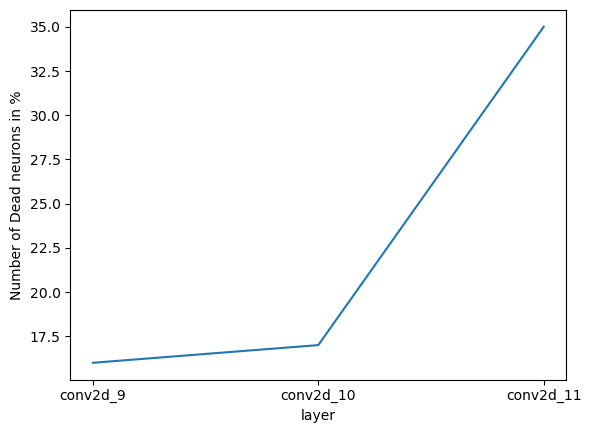

In [63]:
sns.lineplot(data=initial_relu_model_with_aug_neurons, x='layer', y='Number of Dead neurons in %')

In [64]:
initial_relu_model_with_aug_best.evaluate(test_dataset)

204/204 [==============================] - 1s 4ms/step - loss: 0.2236 - accuracy: 0.9400


[0.22356784343719482, 0.9399968981742859]

# Model: Relu Dropout with Augmentation no regulation

In [68]:
initial_relu_model_with_aug_dropout = simple_model_Relu_with_dropout()
initial_relu_model_with_aug_dropout.load_weights("Saved Models/initial_relu_model_with_dropout.weights.h5")

In [69]:
# Compile the model
initial_relu_model_with_aug_dropout.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
initial_relu_model_with_aug_dropout.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_5 (Dropout)         (None, 32, 32, 3)         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                 

In [70]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)


best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath="initial_relu_model_with_aug_dropout_best.keras",
        save_best_only=True,
        monitor="val_loss")
]

# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
#                               patience=5)

initial_relu_model_with_aug_dropout_time = TimeHistory()


initial_relu_model_with_aug_dropout_history = initial_relu_model_with_aug_dropout.fit(
    aug_train_dataset,                                  # Training data and labels
    validation_data=(val_dataset),                  # Validation data and labels
    epochs=100,                                     # Number of epochs
    class_weight=d_class_weights,                   # Adding Class Weights
    callbacks=[best_model, initial_relu_model_with_aug_dropout_time ],             # Callbacks
    verbose=1                                       # Verbosity mode (1 for progress bar)
)

Epoch 1/100
4675/4675 [==============================] - 26s 5ms/step - loss: 1.8750 - accuracy: 0.3187 - val_loss: 0.8708 - val_accuracy: 0.7350
Epoch 2/100
4675/4675 [==============================] - 25s 5ms/step - loss: 1.1704 - accuracy: 0.6200 - val_loss: 0.6657 - val_accuracy: 0.7975
Epoch 3/100
4675/4675 [==============================] - 25s 5ms/step - loss: 1.0532 - accuracy: 0.6612 - val_loss: 0.6005 - val_accuracy: 0.8197
Epoch 4/100
4675/4675 [==============================] - 25s 5ms/step - loss: 1.0043 - accuracy: 0.6780 - val_loss: 0.5795 - val_accuracy: 0.8223
Epoch 5/100
4675/4675 [==============================] - 25s 5ms/step - loss: 0.9810 - accuracy: 0.6861 - val_loss: 0.5694 - val_accuracy: 0.8213
Epoch 6/100
4675/4675 [==============================] - 25s 5ms/step - loss: 0.9650 - accuracy: 0.6933 - val_loss: 0.5621 - val_accuracy: 0.8227
Epoch 7/100
4675/4675 [==============================] - 25s 5ms/step - loss: 0.9520 - accuracy: 0.6966 - val_loss: 0.5528 -

In [77]:
np.save('Saved Models/initial_relu_model_with_aug_dropout_history.npy',initial_relu_model_with_aug_dropout_history.history)
np.save('Saved Models/initial_relu_model_with_aug_dropout_time.npy',initial_relu_model_with_aug_dropout_time.times)
initial_relu_model_with_aug_dropout.save("saved models/initial_relu_model_with_aug_dropout.keras")

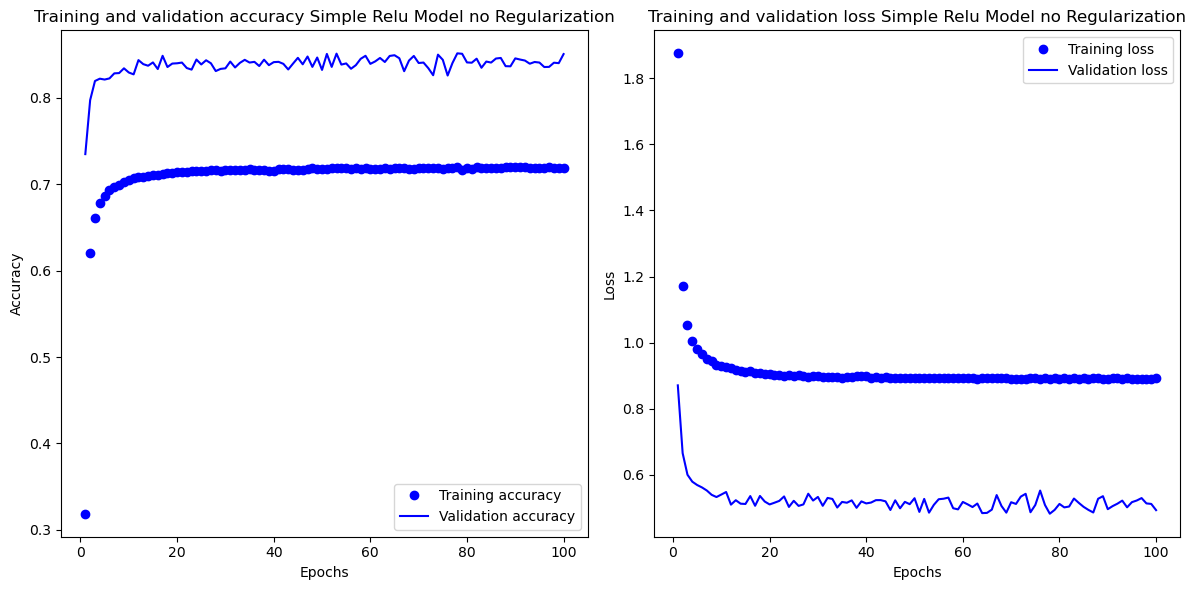

In [78]:
import importlib
import utils.plotting
from utils.plotting import plot_accuracy_metric
importlib.reload(utils.plotting)
import pandas as pd

initial_relu_model_with_aug_dropout_history_pd = pd.DataFrame(initial_relu_model_with_aug_dropout_history.history)

plot_accuracy_metric(initial_relu_model_with_aug_dropout_history_pd, 'Simple Relu Model no Regularization')

Augmentation has reduced the noise in the validation accuracy and loss curves and the cost of some decrease in accuracy and increase in loss in both curves.



In [79]:
initial_relu_model_with_aug_dropout_best = tf.keras.models.load_model('initial_relu_model_with_aug_dropout_best.keras')

In [80]:
import importlib
import utils.statistics
from utils.statistics import count_dead_neurons
importlib.reload(utils.statistics)

relu_with_dropout_aug_best = count_dead_neurons_v2(test_dataset, initial_relu_model_with_aug_dropout_best )

<Axes: xlabel='layer', ylabel='Number of Dead neurons in %'>

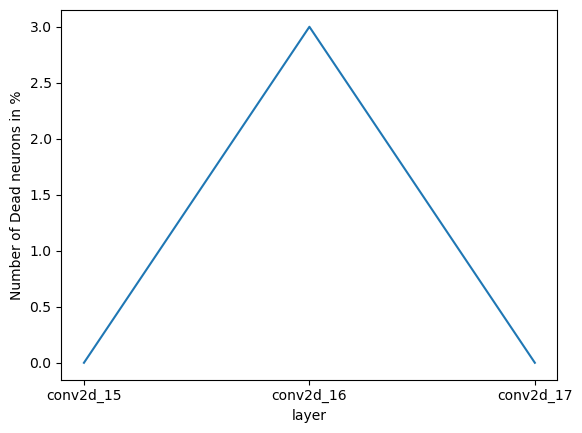

In [81]:
sns.lineplot(data=relu_with_dropout_aug_best, x='layer', y='Number of Dead neurons in %')

# Model: Dropout with Augementation & LR

In [45]:
import tensorflow as tf
import tensorflow_addons as tfa
from keras import activations

# Build the model
aug_dropout = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer

    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),                 # Convolutional layer    
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.5),
    

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),                 # Convolutional layer    
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.5),
    

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),                 # Convolutional layer    
    tf.keras.layers.MaxPooling2D((2, 2)), 
    tf.keras.layers.Dropout(0.5),
       

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(10, activation='softmax'),    # Output layer for 10 classes
    
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
aug_dropout.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
aug_dropout.summary()

Model: "sequential_1"


c:\Users\seand\.conda\envs\Final_Project_tensor-addon\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\seand\.conda\envs\Final_Project_tensor-addon\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounte

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
          

In [46]:
import importlib
import utils.keras_callback
from utils.keras_callback import TimeHistory
importlib.reload(utils.keras_callback)


best_model = [tf.keras.callbacks.ModelCheckpoint(
        filepath="aug_dropout.keras",
        save_best_only=True,
        monitor="val_loss")
]

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5)

aug_dropout_time = TimeHistory()


aug_dropout_history = aug_dropout.fit(
    aug_train_dataset,                                  # Training data and labels
    validation_data=(val_dataset),                  # Validation data and labels
    epochs=100,                                     # Number of epochs
    class_weight=d_class_weights,                   # Adding Class Weights
    callbacks=[best_model, aug_dropout_time, reduce_lr],             # Callbacks
    verbose=1                                       # Verbosity mode (1 for progress bar)
)

Epoch 1/100
4675/4675 [==============================] - 32s 5ms/step - loss: 1.7247 - accuracy: 0.3891 - val_loss: 0.8155 - val_accuracy: 0.7482 - lr: 0.0010
Epoch 2/100
4675/4675 [==============================] - 26s 5ms/step - loss: 1.1321 - accuracy: 0.6342 - val_loss: 0.6724 - val_accuracy: 0.7893 - lr: 0.0010
Epoch 3/100
4675/4675 [==============================] - 26s 5ms/step - loss: 1.0460 - accuracy: 0.6646 - val_loss: 0.6203 - val_accuracy: 0.8087 - lr: 0.0010
Epoch 4/100
4675/4675 [==============================] - 25s 5ms/step - loss: 1.0085 - accuracy: 0.6776 - val_loss: 0.5978 - val_accuracy: 0.8112 - lr: 0.0010
Epoch 5/100
4675/4675 [==============================] - 25s 5ms/step - loss: 0.9842 - accuracy: 0.6860 - val_loss: 0.5956 - val_accuracy: 0.8142 - lr: 0.0010
Epoch 6/100
4675/4675 [==============================] - 25s 5ms/step - loss: 0.9668 - accuracy: 0.6911 - val_loss: 0.5558 - val_accuracy: 0.8278 - lr: 0.0010
Epoch 7/100
4675/4675 [=======================

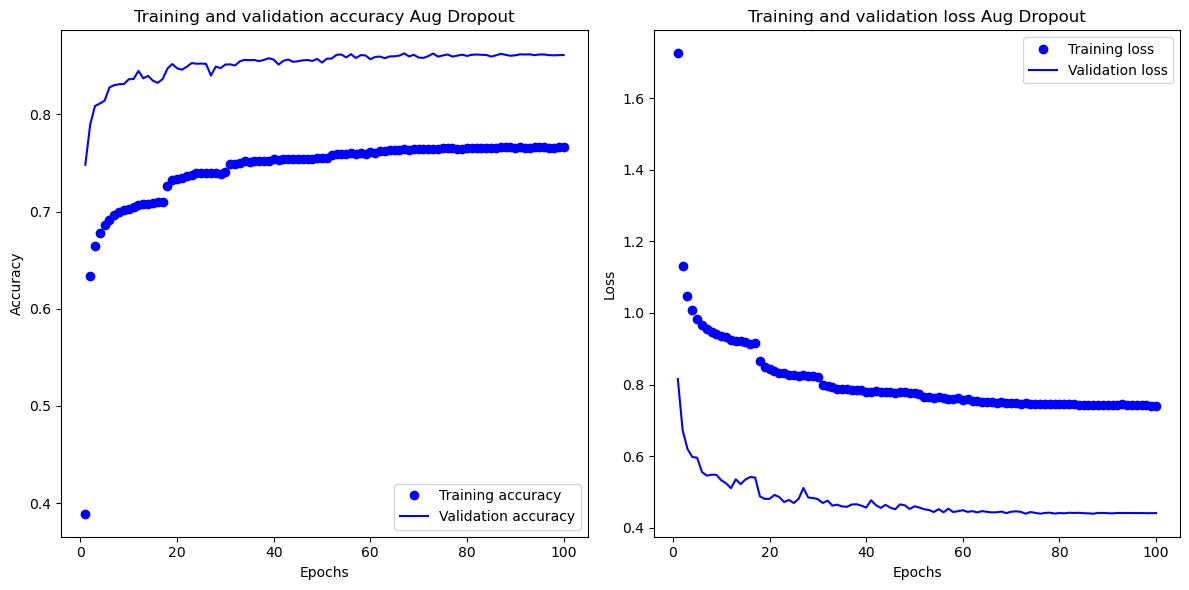

In [47]:
import importlib
import utils.plotting
from utils.plotting import plot_accuracy_metric
importlib.reload(utils.plotting)
import pandas as pd

aug_dropout_history_df = pd.DataFrame(aug_dropout_history.history)

plot_accuracy_metric(aug_dropout_history_df, 'Aug Dropout')

In [465]:
np.save('Saved Models/aug_dropout_history.npy',aug_dropout_history.history)

In [466]:
aug_dropout.save("saved models/aug_dropout.keras")

In [85]:
np.save('Saved Models/aug_dropout_time.npy',aug_dropout_time.times)

# Model: Dropblock with Augmentation

# Clear Memory

In [40]:
import gc
import tensorflow as tf

# Clear memory
gc.collect()
tf.keras.backend.clear_session()